In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#run pipeline - creates and populates image directories
#%run -i 'local_jpg_directory_pipeline.py'   

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:822: DtypeWarning: Columns (9,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exit_ignore=exit_ignore)


In [7]:
import pathlib
data_dir = pathlib.Path('Male_vs_Female')

In [3]:
len_Male = len(os.listdir('Male_vs_Female/By Male'))
len_Female = len(os.listdir('Male_vs_Female/By Female'))
print(f'Male length = {len_Male}')
print(f'Female length = {len_Female}')
difference = len_Male - len_Female
print(f'Subtract {difference} from Male. (Are already randomized)')

Male length = 1995
Female length = 1764
Subtract 231 from Male. (Are already randomized)


In [4]:
for file in os.listdir('Male_vs_Female/By Male')[:231]:
    path = f'Male_vs_Female/By Male/{file}'
    os.remove(path)

In [5]:
len_Male = len(os.listdir('Male_vs_Female/By Male'))
len_Female = len(os.listdir('Male_vs_Female/By Female'))
print(f'Male length = {len_Male}')
print(f'Female length = {len_Female}')
difference = len_Male - len_Female
print(f'Subtract {difference} from Male. (Are already randomized)')

Male length = 1764
Female length = 1764
Subtract 0 from Male. (Are already randomized)


In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3528

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3528 files belonging to 2 classes.
Using 2823 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3528 files belonging to 2 classes.
Using 705 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['By Female', 'By Male']


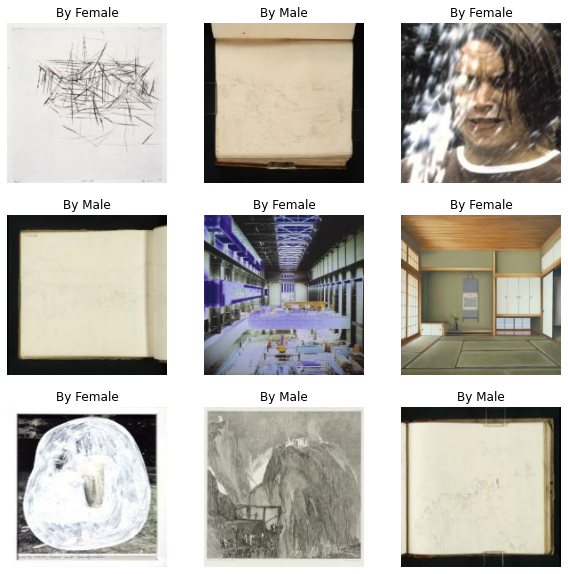

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0016626284 1.0


In [20]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [23]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
89/89 [==============================] - 4s 19ms/step - loss: 0.7598 - accuracy: 0.6329 - val_loss: 0.5138 - val_accuracy: 0.7291
Epoch 2/30
89/89 [==============================] - 1s 8ms/step - loss: 0.4960 - accuracy: 0.7506 - val_loss: 0.5056 - val_accuracy: 0.7504
Epoch 3/30
89/89 [==============================] - 1s 8ms/step - loss: 0.4611 - accuracy: 0.7769 - val_loss: 0.4802 - val_accuracy: 0.7376
Epoch 4/30
89/89 [==============================] - 1s 8ms/step - loss: 0.4327 - accuracy: 0.7815 - val_loss: 0.5268 - val_accuracy: 0.7489
Epoch 5/30
89/89 [==============================] - 1s 8ms/step - loss: 0.4011 - accuracy: 0.8039 - val_loss: 0.5601 - val_accuracy: 0.7191
Epoch 6/30
89/89 [==============================] - 1s 8ms/step - loss: 0.3557 - accuracy: 0.8276 - val_loss: 0.6797 - val_accuracy: 0.7277
Epoch 7/30
89/89 [==============================] - 1s 8ms/step - loss: 0.3119 - accuracy: 0.8560 - val_loss: 0.7159 - val_accuracy: 0.7248
Epoch 8/30
89/89 [=

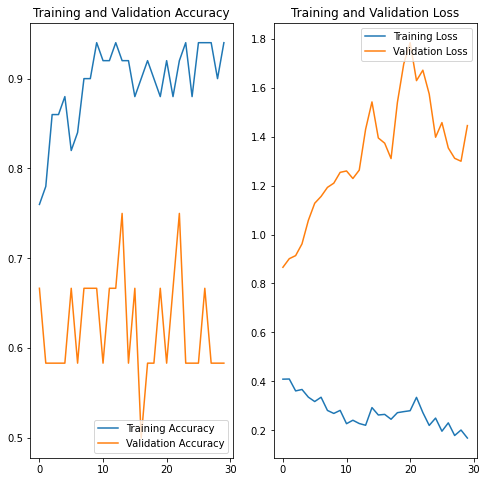

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

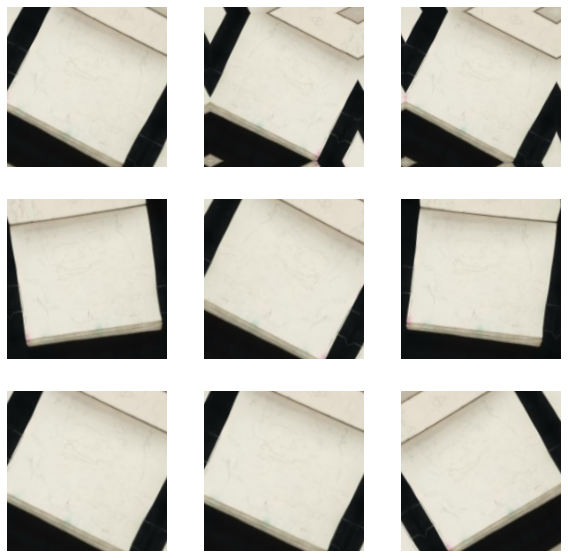

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [26]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [28]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [32]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
89/89 [==============================] - 1s 10ms/step - loss: 0.2615 - accuracy: 0.8813 - val_loss: 0.5899 - val_accuracy: 0.7773
Epoch 2/20
89/89 [==============================] - 1s 10ms/step - loss: 0.2777 - accuracy: 0.8732 - val_loss: 0.6225 - val_accuracy: 0.7858
Epoch 3/20
89/89 [==============================] - 1s 10ms/step - loss: 0.2457 - accuracy: 0.8898 - val_loss: 0.6294 - val_accuracy: 0.7617
Epoch 4/20
89/89 [==============================] - 1s 10ms/step - loss: 0.2515 - accuracy: 0.8891 - val_loss: 0.6375 - val_accuracy: 0.7787
Epoch 5/20
89/89 [==============================] - 1s 10ms/step - loss: 0.2484 - accuracy: 0.8909 - val_loss: 0.6920 - val_accuracy: 0.7887
Epoch 6/20
89/89 [==============================] - 1s 10ms/step - loss: 0.2463 - accuracy: 0.8852 - val_loss: 0.6794 - val_accuracy: 0.7858
Epoch 7/20
89/89 [==============================] - 1s 9ms/step - loss: 0.2347 - accuracy: 0.9022 - val_loss: 0.6975 - val_accuracy: 0.7816
Epoch 8/20
89/

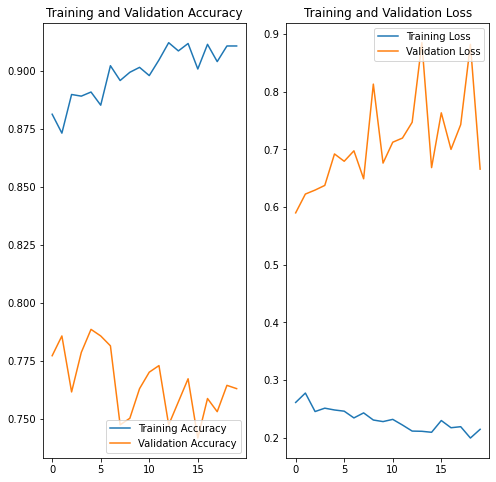

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()